# A pyipr Prymer

The objective of this notebook is to highlight some of the features of the pyipr module.

### Provided Data

We have been provided with a set of well test history, which is comprised of:

 - Bottomhole Pressure ($P_{wf}$) in psig
 - Liquid Rate ($Q_L$) in stb/d
 - Water Cut (WCT) as %
 - Gas Oil Ratio (GOR) in scf/stb

 Lets examine the data

In [7]:
import pandas as pd

# import test history from csv
well_test_df = pd.read_csv('data\\Well 1A Well Test History.csv')
well_test_df['Date'] = pd.to_datetime(well_test_df['Date'], dayfirst=True)

well_test_df.head(10)

,Date,Pwf,QL,WCT,GOR
0,2018-02-15,3200.0,2000.0,9.7,650.1
1,2018-03-19,3155.5,2000.7,9.5,649.0
2,2018-04-23,3108.3,1998.2,9.5,651.9
3,2018-05-27,3063.7,1998.7,8.2,651.2
4,2018-07-03,3009.5,2002.0,11.6,651.8
5,2018-08-07,2973.1,1999.9,9.8,651.8
6,2018-09-11,2927.6,2001.2,8.7,648.5
7,2018-10-13,2881.0,2000.7,8.4,648.1
8,2018-11-18,2846.8,2002.0,11.1,651.7
9,2018-12-23,2809.8,1999.4,10.6,649.2


(645.0, 655.0)

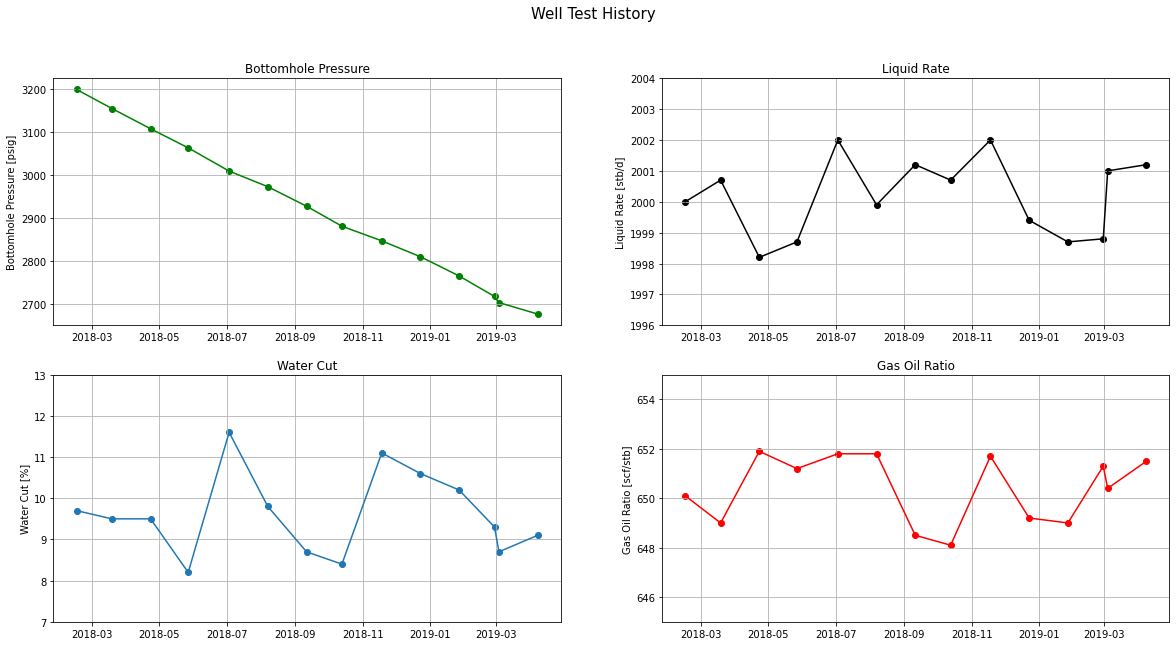

In [12]:
import matplotlib.pyplot as plt

# plot history
fig, axes = plt.subplots(figsize = (20, 10))
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
fig.suptitle('Well Test History', fontsize = 15)

plt.subplot(grid[0, 0])
plt.grid()
plt.title("Bottomhole Pressure")
plt.plot(well_test_df['Date'], well_test_df['Pwf'], color = 'g')
plt.scatter(well_test_df['Date'], well_test_df['Pwf'], color = 'g')
plt.ylabel("Bottomhole Pressure [psig]")

plt.subplot(grid[0, 1])
plt.grid()
plt.title("Liquid Rate")
plt.plot(well_test_df['Date'], well_test_df['QL'], color = 'k')
plt.scatter(well_test_df['Date'], well_test_df['QL'], color = 'k')
plt.ylabel("Liquid Rate [stb/d]")
plt.ylim(1996, 2004)

plt.subplot(grid[1, 0])
plt.grid()
plt.title("Water Cut")
plt.plot(well_test_df['Date'], well_test_df['WCT'])
plt.scatter(well_test_df['Date'], well_test_df['WCT'])
plt.ylabel("Water Cut [%]")
plt.ylim(7, 13)

plt.subplot(grid[1, 1])
plt.grid()
plt.title("Gas Oil Ratio")
plt.plot(well_test_df['Date'], well_test_df['GOR'], color = 'r')
plt.scatter(well_test_df['Date'], well_test_df['GOR'], color = 'r')
plt.ylabel("Gas Oil Ratio [scf/stb]")
plt.ylim(645, 655)

### Saturated or Undersaturated Fluid?

We can estimate the Bubble Point pressure of the fluid using the Glaso Correlation, which is available within the _bo_pvt_funcs.py_ file. This correlation uses the fluid Gas-Oil Ratio, Oil Density and Gas Gravity to estimate the bubble point pressure at Reservoir Temperature. For the well in question, we have been provided with the fluid information below:
 - Gas Oil Ratio: $\quad 650 \space \text{scf/stb}$
 - Oil Density: $\quad 40.0 \space \text{API}$
 - Gas Gravity: $\quad 0.75$ (air = 1.0)
 - Reservoir Temperature: $\quad 160^{\circ} F$ 

In [13]:
import src.bo_pvt_funcs as bo
# instantiate PVTModel class
pvt_model = bo.PVTModel()
pvt_model.set_params(rsi = 650.0, gasSG= 0.75, oilAPI=40.0)
#calculate bubble point pressure with glaso correlation
p_bub = pvt_model.calc_pbub_glaso(tempF = 160) 
print('Bubble Point Pressure of %0.2f psig' % p_bub)

Bubble Point Pressure of 2598.56 psig


Our estimated bubble point pressure from the Glaso Correlation is below our recorded bottomhole pressures, indicating that we should only be seeing single phase liquid entering our well from the reservoir. This is also consistent with our recorded Gas-Oil Ratio (GOR), which is close to the reported 650 scf/stb from the fluid data.

### Constructing an Inflow Performance Model (IPR)

For the first day of the well test history, we can construct an IPR curve using the liquid rate, bottomhole pressure and reservoir pressure. Before the start of the well test history, it is believed the well had a reservoir pressure of 4100 psig. The IPR also needs the bubble point pressure to know when to transition between the Darcy (PI) and Vogel IPR.

In [14]:
import src.pyipr as pyipr

well_1A = pyipr.IPR()
well_1A.set_params(res_p = 4100, res_t = 160, pvt = pvt_model)
well_1A.type = "Test"
well_1A.test_ql = well_test_df['QL'][0] #set test liquid rate, stb/d
well_1A.test_bhp = well_test_df['Pwf'][0]  #set test bhp, psig
well_1A_ipr = pd.DataFrame(well_1A.get_ipr())

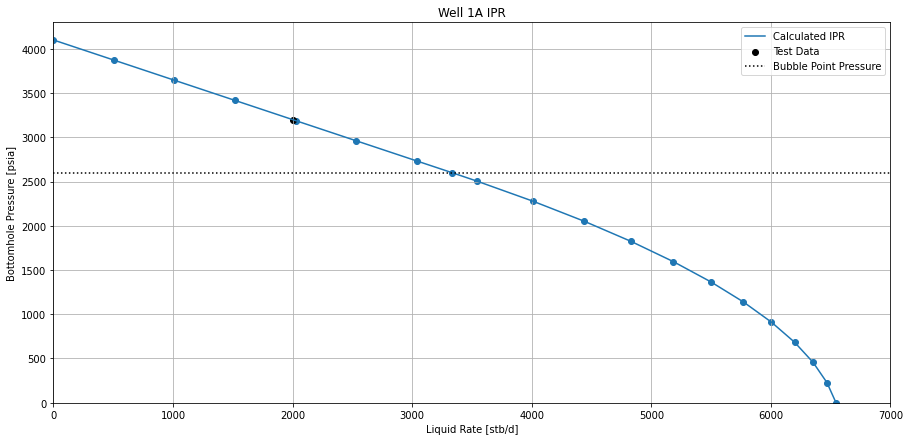

In [15]:
fig, axes = plt.subplots(figsize = (15, 7))
plt.grid()
plt.plot(well_1A_ipr['LiqRate'], well_1A_ipr['Pwf'], label='Calculated IPR')
plt.scatter(well_1A_ipr['LiqRate'], well_1A_ipr['Pwf'])
plt.scatter(well_1A.test_ql, well_1A.test_bhp, color='k', label='Test Data')
plt.hlines(well_1A.pbub, -1, 7000, linestyles='dotted', colors='k', label='Bubble Point Pressure')
plt.xlim(0, 7000)
plt.ylim(-1, 4300)
plt.ylabel('Bottomhole Pressure [psia]')
plt.xlabel('Liquid Rate [stb/d]')
plt.title('Well 1A IPR')
plt.legend()

### Estimating the Productivity Index (PI)

The IPR above has two distinct zones for above and below the bubble point. 

Above the bubble point, fluid flow from the reservoir into the completion will be single phase and so we can use the Darcy IPR:

$$ Q_{L} = \frac{2\pi kh}{\ln \frac {r_e}{r_w}} \frac {k_r B}{\mu} \left( P_R - P_{wf} \right) $$

We can substitute the rock properties (i.e. $k, h, r_e, r_w$) and the fluid properties (i.e. $k_r, B, \mu$) with a constant known as the _Productivity Index (PI)_ and use the following form:

$$ Q_{L} = PI (P_R - P_{wf}) $$

Below the bubble point, we can use the Vogel IPR which was specifically designed for oil wells producing below the initial bubble point pressure and therefore with free gas flowing from the reservoir into the completion. The Vogel IPR has the following form:

$$ \frac{Q}{Q_{max}} = 1 - 0.2 \frac{P_{wf}}{P_{b}} - 0.8\frac{P_{wf}}{P_{b}}^2$$

This IPR reflects a reducing productivity at lower bottomhole pressure due to the relative permeability effects from more free gas present.

We can also return the resulting Productivity Index (PI) from the test, which is calculated via:

$$ PI = \frac{Q_{L}}{P_{R} - P_{wf}}$$

where:
 - $PI:$  Productivity Index (stb/d/psi)
 - $P_{R}:$ Reservoir Pressure (psia)
 - $P_{wf}:$ Bottomhole Pressure (psia)

In [16]:
print('Well 1A PI is %0.3f' % well_1A.pi)

Well 1A PI is 2.222


If our test point was below the bubble point pressure, we can calculate the PI using the Vogel IPR as follows:

$$ PI = \frac {Q_L}{P_R-P_b - \frac{P_b}{1.8} \left(1 - 0.2 \frac{P_{wf}}{P_{b}} - 0.8\frac{P_{wf}}{P_{b}}^2\right)} $$

Using a point with a bottomhole pressur below the bubble point pressure from the IPR, we can recalculate the IPR and show the reported PI is equivalent. The IPR model will use the Vogel IPR up to the bubble point pressure and then use the gradient at the bubble point until the Reservoir Pressure. The reported PI should be the same as reported above 

In [17]:
well_1A_dummy = pyipr.IPR() #create instance of IPR object
well_1A_dummy.set_params(4100, 160, pvt_model)

well_1A_dummy.test_ql = 5497.279 #set test liquid rate, stb/d, taken from well_1A_ipr
well_1A_dummy.test_bhp = 1366.667 #set test bhp, psig, taken from well_1A_ipr
well_1A_dummy.pi = well_1A_dummy.calc_PI(well_1A_dummy.test_bhp, well_1A_dummy.test_ql)

print('Well 1A Dummy PI is %0.3f' % well_1A_dummy.pi)

Well 1A Dummy PI is 2.222


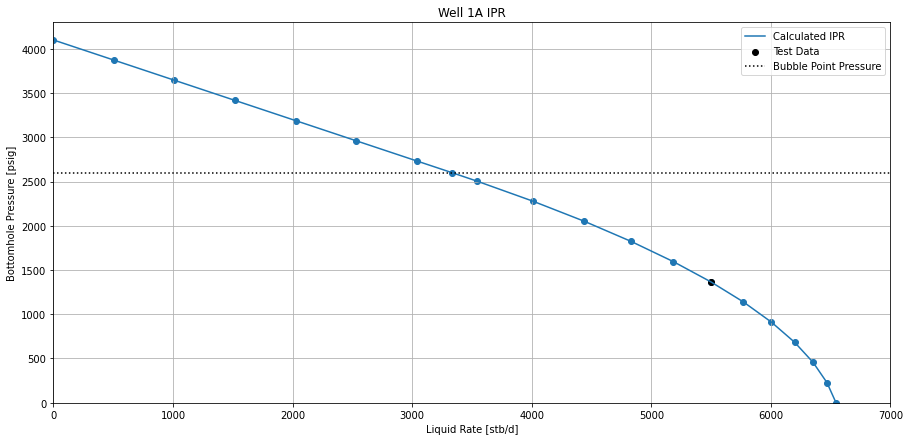

In [18]:
well_1A_dummy_ipr = pd.DataFrame(well_1A_dummy.get_ipr())

fig, axes = plt.subplots(figsize = (15, 7))
plt.grid()
plt.plot(well_1A_dummy_ipr['LiqRate'], well_1A_dummy_ipr['Pwf'], label='Calculated IPR')
plt.scatter(well_1A_dummy_ipr['LiqRate'], well_1A_dummy_ipr['Pwf'])
plt.scatter(well_1A_dummy.test_ql, well_1A_dummy.test_bhp, color='k', label='Test Data')
plt.hlines(well_1A.pbub, -1, 7000, linestyles='dotted', colors='k', label='Bubble Point Pressure')
plt.xlim(0, 7000)
plt.ylim(-1, 4300)
plt.ylabel('Bottomhole Pressure [psig]')
plt.xlabel('Liquid Rate [stb/d]')
plt.title('Well 1A IPR')
plt.legend()

Lets repeat this process for the rest of the tests, assuming the reservoir pressure is constant over the well test history

Text(0.5, 1.0, 'Well 1A')

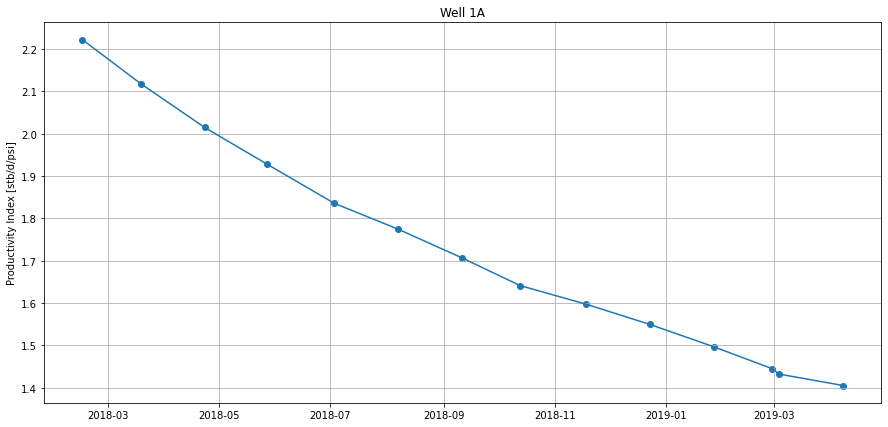

In [19]:
well_test_df['PI'] = well_test_df.apply(
    lambda x: well_1A.calc_PI(x.Pwf, x.QL), axis=1
)

fig, axes = plt.subplots(figsize = (15, 7))
plt.grid()
plt.plot(well_test_df['Date'], well_test_df['PI'])
plt.scatter(well_test_df['Date'], well_test_df['PI'])
plt.ylabel('Productivity Index [stb/d/psi]')
plt.title('Well 1A')

Therefore, for each test, we can construct the following IPRs

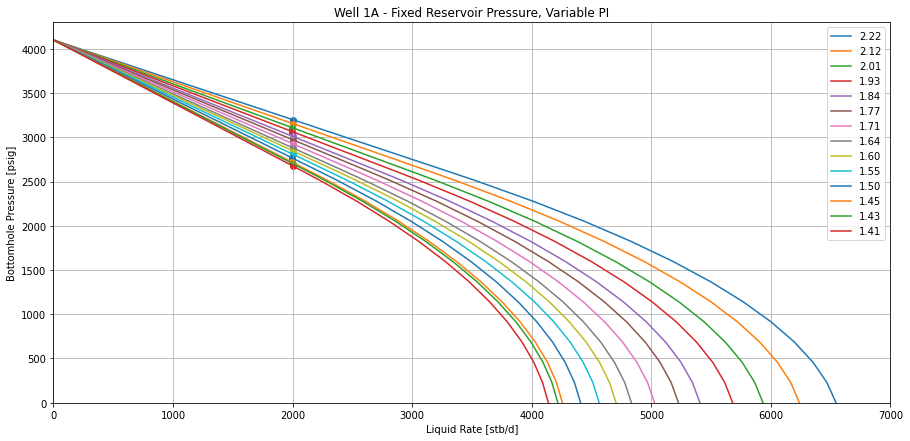

In [20]:
fig, axes = plt.subplots(figsize = (15, 7))
plt.grid()
well_1A.type = "PI"
for i, pi in enumerate(well_test_df['PI'].values):
    well_1A.pi = pi
    temp_ipr = pd.DataFrame(well_1A.get_ipr()) 
    plt.plot(temp_ipr['LiqRate'], temp_ipr['Pwf'], label='%0.2f' % pi)
    plt.scatter(well_test_df['QL'][i], well_test_df['Pwf'][i])
    
plt.ylabel('Bottomhole Pressure [psig]')
plt.xlabel('Liquid Rate [stb/d]')
plt.title('Well 1A - Fixed Reservoir Pressure, Variable PI')
plt.xlim(0, 7000)
plt.ylim(-1, 4300)
plt.ylabel('Bottomhole Pressure [psig]')
plt.xlabel('Liquid Rate [stb/d]')
plt.legend()

### The Effect of Phase Mobility on Productivity Index 

We can see the PI reducing over the test history, which if true, must be a result of phase mobility. Given our understanding of the Darcy IPR, we can define the PI as:

$$ PI = \frac{2\pi kh}{\ln \frac {r_e}{r_w}} \times \frac {k_rB}{\mu}$$

This PI has two distinct parts, rock properties (i.e. $k, h, r_e, r_w$) and fluid properties (i.e. $k_r, B, \mu$). The rock properties arond the well will remain the same and so the only way PI can change will be the via fluid properties. We can also expect the PI to change as the secondary phases (i.e. water and gas) change around the well as this will have a relative permeability effect. The oil phase will have to compete with the other non-miscible phases for space in the pore throats to flow. 

Shown below is the Water-Cut (WCT) and Gas-Oil Ratio (GOR) for each test plotted against the estimated PI, demonstrating that there is no trend between changing PI and GOR or WCT

Text(0.5, 0, 'WCT [%]')

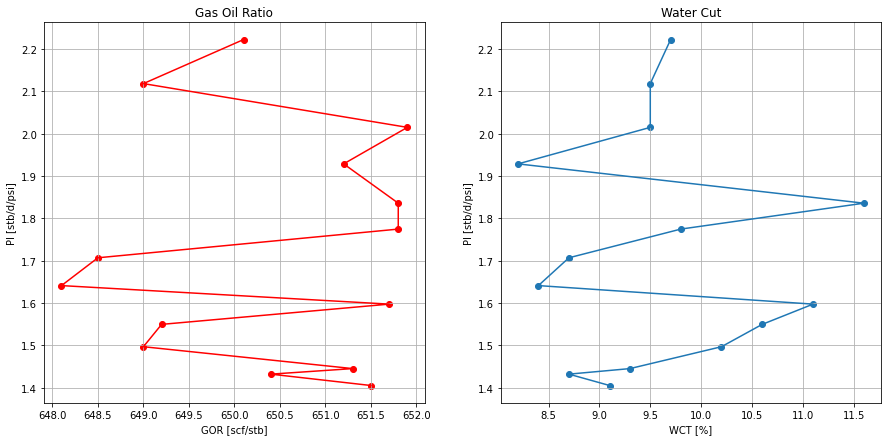

In [24]:
fig, axes = plt.subplots(figsize = (15, 7))
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)

plt.subplot(grid[0, 0])
plt.grid()
plt.title("Gas Oil Ratio")
plt.plot(well_test_df['GOR'], well_test_df['PI'], color = 'r')
plt.scatter(well_test_df['GOR'], well_test_df['PI'], color = 'r')
plt.ylabel("PI [stb/d/psi]")
plt.xlabel("GOR [scf/stb]")

plt.subplot(grid[0, 1])
plt.grid()
plt.title("Water Cut")
plt.plot(well_test_df['WCT'], well_test_df['PI'])
plt.scatter(well_test_df['WCT'], well_test_df['PI'])
plt.ylabel("PI [stb/d/psi]")
plt.xlabel("WCT [%]")

### Reservoir Pressure

Based on the plots above, it is more likely that Reservoir Pressure is changing and the PI is the same for the well test history. Using the same PI, lets calculate the changing reservoir pressure using the well test history (i.e Pwf and QL)

Text(0.5, 1.0, 'Well 1A')

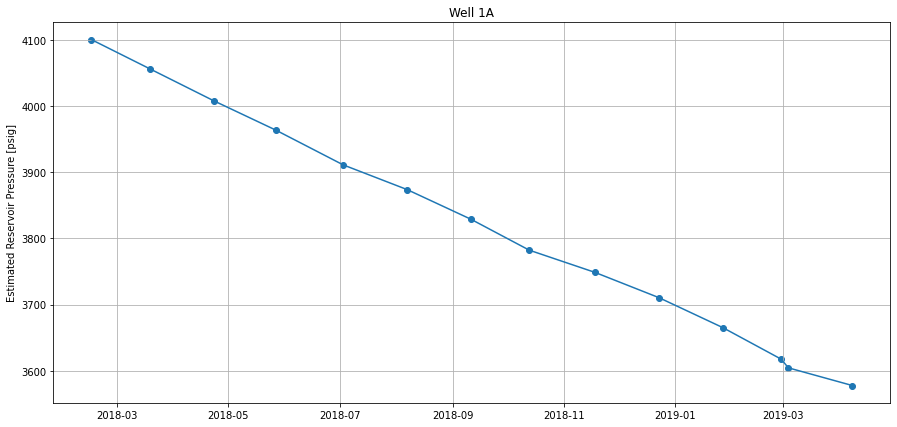

In [22]:
well_1A.pi = 2.22
well_test_df['Estimated ResP'] = well_test_df.apply(
    lambda x: well_1A.calc_res_p(x.Pwf, x.QL), axis=1
)

fig, axes = plt.subplots(figsize = (15, 7))
plt.grid()
plt.plot(well_test_df['Date'], well_test_df['Estimated ResP'])
plt.scatter(well_test_df['Date'], well_test_df['Estimated ResP'])
plt.ylabel('Estimated Reservoir Pressure [psig]')
plt.title('Well 1A')

We can see that by using the same PI, we can estimate reservoir pressure for each well test. The estimated reservoir pressure is declining over time, which is to be expected. Using these reservoir pressures, we can create IPRs for each test

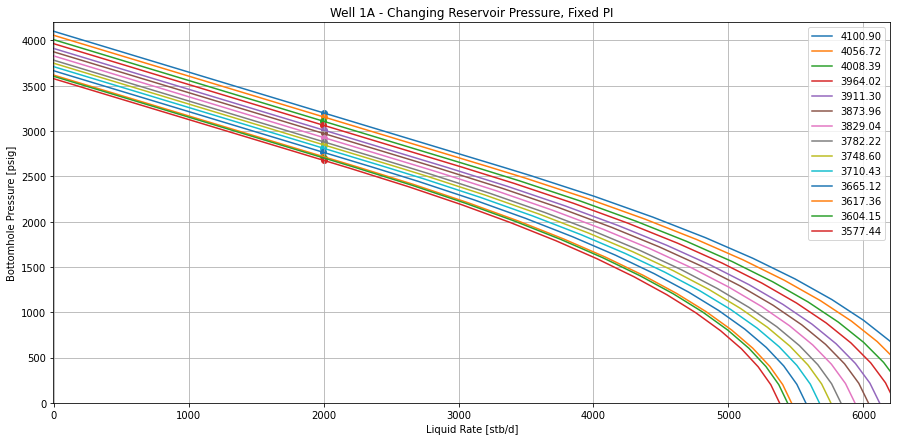

In [27]:
fig, axes = plt.subplots(figsize = (15, 7))
for i, res_p in enumerate(well_test_df['Estimated ResP'].values):
    well_1A.res_p = res_p
    temp_ipr = pd.DataFrame(well_1A.get_ipr()) 
    plt.plot(temp_ipr['LiqRate'], temp_ipr['Pwf'], label='%0.2f' % res_p)
    plt.scatter(well_test_df['QL'][i], well_test_df['Pwf'][i])

plt.grid()
plt.ylabel('Bottomhole Pressure [psig]')
plt.xlabel('Liquid Rate [stb/d]')
plt.title('Well 1A - Changing Reservoir Pressure, Fixed PI')
plt.xlim(-1, 6200)
plt.ylim(0, 4200)
plt.legend()